# 📊 Submission Results Comparison

**목적**: submissions 폴더의 각 날짜별 CSV 결과 파일들을 비교 분석합니다.

## 📋 분석 내용
1. **파일 개요**: 각 날짜별 제출 파일 현황
2. **예측 분포**: 클래스별 예측 분포 비교
3. **예측 차이**: 모델간 예측 결과 차이점 분석
4. **성능 추정**: 예측 신뢰도 및 일관성 평가
5. **시각화**: 인터랙티브 차트로 결과 비교

In [1]:
# [1] 프로젝트 루트 디렉토리로 이동
import os                                                   # OS 모듈 임포트
import sys                                                  # 시스템 모듈 임포트
os.chdir("../../../")                                       # 프로젝트 루트로 이동
print("현재 작업 디렉토리:", os.getcwd())                      # 현재 디렉토리 출력

현재 작업 디렉토리: /home/ieyeppo/AI_Lab/computer-vision-competition-1SEN


In [2]:
# [2] 폰트 설정 및 경고 억제
# 경고 억제 설정
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 적용 및 시각화 환경 설정
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 나눔고딕 폰트 경로 및 설정
font_path = './font/NanumGothic.ttf'
fontprop = fm.FontProperties(fname=font_path)

# 폰트 등록 및 설정 (한글 텍스트 표시를 위함)
fe = fm.FontEntry(fname=font_path, name='NanumGothic')
fm.fontManager.ttflist.insert(0, fe)
plt.rcParams['font.family'] = 'NanumGothic'      # 기본 폰트를 나눔고딕으로 설정
plt.rcParams['font.size'] = 10                   # 기본 글자 크기 설정
plt.rcParams['axes.unicode_minus'] = False       # 마이너스 기호 깨짐 방지

# 글자 겹침 방지를 위한 레이아웃 설정
plt.rcParams['figure.autolayout'] = True         # 자동 레이아웃 조정
plt.rcParams['axes.titlepad'] = 20               # 제목과 축 사이 여백

# 폰트 로드 확인
try:
    test_font = fm.FontProperties(fname=font_path)
    print("✅ 나눔고딕 폰트 로드 성공")
except Exception as e:
    print(f"❌ 폰트 로드 실패: {e}")

✅ 나눔고딕 폰트 로드 성공


In [3]:
# [3] 필수 라이브러리 임포트 및 설정
# 데이터 처리 라이브러리
import pandas as pd                               # 데이터프레임 처리
import numpy as np                                # 수치 연산

# 시각화 라이브러리
import matplotlib.pyplot as plt                   # 정적 차트 생성
import seaborn as sns                             # 통계 시각화
import plotly.express as px                       # 인터랙티브 차트
import plotly.graph_objects as go                 # plotly 그래프 객체
from plotly.subplots import make_subplots         # 서브플롯 생성

# 시스템 및 파일 처리
import os                                         # 운영체제 인터페이스
from pathlib import Path                          # 경로 처리
from datetime import datetime                     # 날짜/시간 처리

# 프로젝트 로깅 시스템
from src.logging.notebook_logger import NotebookLogger, create_notebook_logger

# 시각화 스타일 설정
sns.set_style("whitegrid")                        # seaborn 스타일 설정
plt.style.use('seaborn-v0_8')                     # matplotlib 스타일 설정

print("✅ 라이브러리 로드 완료!")

✅ 라이브러리 로드 완료!


In [1]:
# [4] 결과 저장을 위한 로깅 시스템 초기화
# 노트북 실행 결과를 체계적으로 저장하기 위한 로거 설정
file_name = "submission_results_date_comparison"    # 현재 노트북 파일명
base_log_dir = "modular"                            # notebooks 폴더 내 기본 저장 경로
folder_name = "results_comparison"                  # 결과 저장 폴더명

# NotebookLogger 인스턴스 생성
logger = create_notebook_logger(
    base_log_dir="modular",                         # notebooks 폴더 내 기본 저장 경로
    folder_name="results_comparison",               # results_comparison 폴더 지정
    file_name=file_name                             # 파일명으로 폴더 생성됨
)

print(f"📁 결과 저장 경로: {logger.log_dir}")
print(f"🕐 실행 시간: {logger.timestamp}")
print("✅ 로깅 시스템 초기화 완료!")

NameError: name 'create_notebook_logger' is not defined

In [5]:
# [5] Submission 파일 탐색 및 수집
# submissions 폴더에서 날짜별로 구조화된 CSV 파일들을 탐색
submissions_dir = Path("./submissions")
print(f'📂 Submissions 디렉토리: {submissions_dir}')

# 날짜별 submission 파일 매핑 딕셔너리
submission_files = {}

# submissions 폴더 내 모든 하위 디렉토리 탐색
for date_dir in sorted(submissions_dir.iterdir()):
    # 8자리 숫자로 구성된 날짜 폴더만 처리 (YYYYMMDD 형식)
    if date_dir.is_dir() and date_dir.name.isdigit() and len(date_dir.name) == 8:
        date = date_dir.name
        csv_files = list(date_dir.glob("*.csv"))  # 해당 날짜 폴더의 모든 CSV 파일
        
        if csv_files:
            submission_files[date] = csv_files
            print(f"📅 {date}: {len(csv_files)}개 파일 발견")
            for file in csv_files:
                print(f"   - {file.name}")

print(f"\n🎯 총 {len(submission_files)}개 날짜, {sum(len(files) for files in submission_files.values())}개 파일 발견")

📂 Submissions 디렉토리: submissions
📅 20250903: 1개 파일 발견
   - baseline_code_pred.csv
📅 20250904: 1개 파일 발견
   - infer.csv
📅 20250905: 2개 파일 발견
   - swin-sighperf_ensemble_20250905_1522.csv
   - efficientnet_b3_ensemble_20250905_1345.csv
📅 20250906: 2개 파일 발견
   - swin-sighperf_ensemble_20250906_2213.csv
   - efficientnet_b3_ensemble_20250906_2157.csv
📅 20250907: 2개 파일 발견
   - swin-sighperf_ensemble_20250907_0035.csv
   - efficientnet_b3_ensemble_20250907_0016.csv

🎯 총 5개 날짜, 8개 파일 발견


In [6]:
# [6] Submission 데이터 로드 및 모델 정보 추출
# 발견된 모든 CSV 파일을 로드하고 모델 정보를 추출하여 구조화
submission_data = {}

for date, files in submission_files.items():
    submission_data[date] = {}
    
    for file_path in files:
        try:
            # CSV 파일 로드
            df = pd.read_csv(file_path)
            
            # 파일명에서 모델 타입 자동 추출
            model_name = file_path.stem
            if "efficientnet" in model_name.lower():
                model_type = "EfficientNet"
            elif "swin" in model_name.lower():
                model_type = "Swin"
            else:
                model_type = "Unknown"
            
            # 데이터와 메타정보를 함께 저장
            submission_data[date][model_name] = {
                'data': df,                    # 실제 예측 데이터
                'model_type': model_type,      # 모델 타입 분류
                'file_path': str(file_path)    # 원본 파일 경로
            }
            
            print(f"✅ {date}/{model_name}: {len(df)}개 샘플 로드 완료")
            
        except Exception as e:
            print(f"❌ {file_path} 로드 실패: {e}")

print("\n📊 데이터 로드 완료!")

✅ 20250903/baseline_code_pred: 3140개 샘플 로드 완료
✅ 20250904/infer: 3140개 샘플 로드 완료
✅ 20250905/swin-sighperf_ensemble_20250905_1522: 3140개 샘플 로드 완료
✅ 20250905/efficientnet_b3_ensemble_20250905_1345: 3140개 샘플 로드 완료
✅ 20250906/swin-sighperf_ensemble_20250906_2213: 3140개 샘플 로드 완료
✅ 20250906/efficientnet_b3_ensemble_20250906_2157: 3140개 샘플 로드 완료
✅ 20250907/swin-sighperf_ensemble_20250907_0035: 3140개 샘플 로드 완료
✅ 20250907/efficientnet_b3_ensemble_20250907_0016: 3140개 샘플 로드 완료

📊 데이터 로드 완료!


In [7]:
# [7] 로드된 데이터 기본 정보 출력 및 검증
# 각 날짜별, 모델별 데이터의 기본 구조와 통계 정보 출력
print("📋 Submission Files Overview")
print("=" * 80)

for date in sorted(submission_data.keys()):
    print(f"\n📅 {date}")
    print("-" * 40)
    
    for model_name, info in submission_data[date].items():
        df = info['data']                     # 예측 데이터
        model_type = info['model_type']       # 모델 타입
        
        print(f"🤖 {model_name} ({model_type})")
        print(f"   - 샘플 수: {len(df):,}")
        print(f"   - 컬럼: {list(df.columns)}")
        
        # target 컬럼이 있는 경우 예측 분포 정보도 출력
        if 'target' in df.columns:
            unique_classes = df['target'].nunique()
            print(f"   - 예측 클래스 수: {unique_classes}")
            print(f"   - 클래스 분포 (상위3): {dict(df['target'].value_counts().head(3))}")

📋 Submission Files Overview

📅 20250903
----------------------------------------
🤖 baseline_code_pred (Unknown)
   - 샘플 수: 3,140
   - 컬럼: ['ID', 'target']
   - 예측 클래스 수: 15
   - 클래스 분포 (상위3): {9: np.int64(709), 16: np.int64(421), 0: np.int64(313)}

📅 20250904
----------------------------------------
🤖 infer (Unknown)
   - 샘플 수: 3,140
   - 컬럼: ['ID', 'target']
   - 예측 클래스 수: 17
   - 클래스 분포 (상위3): {6: np.int64(620), 13: np.int64(242), 10: np.int64(227)}

📅 20250905
----------------------------------------
🤖 swin-sighperf_ensemble_20250905_1522 (Swin)
   - 샘플 수: 3,140
   - 컬럼: ['ID', 'target']
   - 예측 클래스 수: 17
   - 클래스 분포 (상위3): {7: np.int64(219), 4: np.int64(214), 6: np.int64(207)}
🤖 efficientnet_b3_ensemble_20250905_1345 (EfficientNet)
   - 샘플 수: 3,140
   - 컬럼: ['ID', 'target']
   - 예측 클래스 수: 17
   - 클래스 분포 (상위3): {10: np.int64(238), 4: np.int64(233), 6: np.int64(205)}

📅 20250906
----------------------------------------
🤖 swin-sighperf_ensemble_20250906_2213 (Swin)
   - 샘플 수: 3,140
  

In [8]:
# [8] 클래스별 예측 분포 비교 시각화
def plot_prediction_distribution():
    """
    날짜별/모델별 예측 클래스 분포를 비교하는 인터랙티브 차트 생성
    - 각 날짜별로 서브플롯 생성
    - 모델별로 다른 색상 적용
    - 한글 제목 및 라벨 지원
    """
    # 서브플롯 구성: 날짜별로 행 분할
    fig = make_subplots(
        rows=len(submission_data), 
        cols=1,
        subplot_titles=[f"📅 {date}" for date in sorted(submission_data.keys())],
        vertical_spacing=0.08
    )
    
    # 모델별 색상 팔레트 정의
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']
    
    # 각 날짜별로 데이터 처리
    for i, date in enumerate(sorted(submission_data.keys()), 1):
        for j, (model_name, info) in enumerate(submission_data[date].items()):
            df = info['data']
            
            if 'target' in df.columns:
                # 클래스별 예측 횟수 집계 (클래스 ID 순으로 정렬)
                class_counts = df['target'].value_counts().sort_index()
                
                # 막대 차트 추가
                fig.add_trace(
                    go.Bar(
                        x=class_counts.index,
                        y=class_counts.values,
                        name=f"{info['model_type']}",
                        marker_color=colors[j % len(colors)],
                        showlegend=(i == 1)  # 첫 번째 subplot에서만 범례 표시
                    ),
                    row=i, col=1
                )
    
    # 레이아웃 설정 (한글 지원)
    fig.update_layout(
        height=300 * len(submission_data),
        title="📊 날짜별/모델별 예측 클래스 분포",
        title_font_size=20,
        font=dict(family="NanumGothic, Arial, sans-serif")  # 한글 폰트 명시적 설정
    )
    
    # 축 라벨 설정
    fig.update_xaxes(title_text="Class ID")
    fig.update_yaxes(title_text="Count")
    
    return fig

# 차트 생성 및 표시
distribution_fig = plot_prediction_distribution()
distribution_fig.show()

# 이미지 저장 (한글 폰트 적용된 matplotlib 버전)
try:
    # plotly를 matplotlib로 변환하여 한글 폰트 적용해서 저장
    import matplotlib.pyplot as plt
    import matplotlib.font_manager as fm
    
    # 한글 폰트 재설정 (함수 내에서 명시적 적용)
    font_path = './font/NanumGothic.ttf'
    fontprop = fm.FontProperties(fname=font_path)
    plt.rcParams['font.family'] = 'NanumGothic'
    plt.rcParams['axes.unicode_minus'] = False
    
    # matplotlib로 동일한 차트 재생성
    fig_rows = len(submission_data)
    fig, axes = plt.subplots(fig_rows, 1, figsize=(12, 6*fig_rows))
    if fig_rows == 1:
        axes = [axes]  # 단일 subplot인 경우 리스트로 변환
    
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']
    
    for i, date in enumerate(sorted(submission_data.keys())):
        ax = axes[i]
        
        for j, (model_name, info) in enumerate(submission_data[date].items()):
            df = info['data']
            
            if 'target' in df.columns:
                class_counts = df['target'].value_counts().sort_index()
                ax.bar(class_counts.index, class_counts.values, 
                      color=colors[j % len(colors)], alpha=0.7,
                      label=f"{info['model_type']}")
        
        ax.set_title(f"📅 {date}", fontproperties=fontprop, fontsize=14)
        ax.set_xlabel("Class ID", fontproperties=fontprop)
        ax.set_ylabel("Count", fontproperties=fontprop)
        ax.legend(prop=fontprop)
        ax.grid(True, alpha=0.3)
    
    plt.suptitle("📊 날짜별/모델별 예측 클래스 분포", fontproperties=fontprop, fontsize=16)
    plt.tight_layout()
    
    # 이미지 저장
    save_path = logger.image_dir / "prediction_distribution.png"
    plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
    plt.close()
    
    print(f"📊 예측 분포 차트 저장: {save_path}")
    
except Exception as e:
    print(f"❌ 이미지 저장 실패: {e}")

📊 예측 분포 차트 저장: notebooks/modular/results_comparison/submission_results_date_comparison/20250907_065923/images/prediction_distribution.png


In [9]:
# [9] 모델간 예측 차이 분석 (같은 날짜 내 모델 비교)
def analyze_prediction_differences():
    """
    동일 날짜에 여러 모델이 있는 경우 모델간 예측 차이를 분석
    - ID별로 매칭하여 예측 결과 비교
    - 차이 비율 및 절대 개수 계산
    - 모든 모델 쌍에 대해 분석 수행
    """
    differences = {}
    
    for date, models in submission_data.items():
        if len(models) > 1:  # 2개 이상의 모델이 있는 경우만 비교 가능
            model_names = list(models.keys())
            differences[date] = {}
            
            # 모든 모델 쌍에 대해 차이 계산 (조합)
            for i in range(len(model_names)):
                for j in range(i+1, len(model_names)):
                    model1_name = model_names[i]
                    model2_name = model_names[j]
                    
                    df1 = models[model1_name]['data']
                    df2 = models[model2_name]['data']
                    
                    if 'target' in df1.columns and 'target' in df2.columns:
                        # ID로 매칭하여 차이 계산 (같은 샘플에 대한 예측 비교)
                        merged = pd.merge(df1, df2, on='ID', suffixes=('_1', '_2'))
                        
                        # 예측이 다른 샘플 비율 계산
                        diff_ratio = (merged['target_1'] != merged['target_2']).mean()
                        
                        # 모델 쌍 이름 생성
                        pair_name = f"{models[model1_name]['model_type']} vs {models[model2_name]['model_type']}"
                        differences[date][pair_name] = {
                            'diff_ratio': diff_ratio,
                            'diff_count': (merged['target_1'] != merged['target_2']).sum(),
                            'total_count': len(merged)
                        }
                        
                        print(f"📅 {date} - {pair_name}:")
                        print(f"   예측 차이 비율: {diff_ratio:.1%} ({(merged['target_1'] != merged['target_2']).sum():,}/{len(merged):,})")
    
    return differences

# 차이 분석 실행
prediction_diffs = analyze_prediction_differences()

📅 20250905 - Swin vs EfficientNet:
   예측 차이 비율: 7.5% (235/3,140)
📅 20250906 - Swin vs EfficientNet:
   예측 차이 비율: 7.5% (235/3,140)
📅 20250907 - Swin vs EfficientNet:
   예측 차이 비율: 7.5% (235/3,140)


In [10]:
# [10] 예측 차이 시각화 및 저장
def plot_prediction_differences(differences):
    """
    모델간 예측 차이를 시각화하는 막대 차트 생성
    - 날짜별, 모델 쌍별 차이 비율 표시
    - 차이 개수를 텍스트로 표시
    - 한글 라벨 및 제목 지원
    """
    if not differences:
        print("⚠️ 비교할 모델 쌍이 없습니다.")
        return
    
    # 차이 데이터를 DataFrame으로 변환
    diff_data = []
    for date, pairs in differences.items():
        for pair_name, stats in pairs.items():
            diff_data.append({
                'Date': date,
                'Model_Pair': pair_name,
                'Difference_Ratio': stats['diff_ratio'],
                'Difference_Count': stats['diff_count'],
                'Total_Count': stats['total_count']
            })
    
    if not diff_data:
        print("⚠️ 차이 데이터가 없습니다.")
        return
    
    diff_df = pd.DataFrame(diff_data)
    
    # plotly 막대 차트 생성
    fig = px.bar(
        diff_df, 
        x='Date', 
        y='Difference_Ratio', 
        color='Model_Pair',
        title="🔄 모델간 예측 차이 비율",
        labels={'Difference_Ratio': '예측 차이 비율', 'Date': '날짜'},
        text='Difference_Count'
    )
    
    # 차트 스타일 설정
    fig.update_traces(texttemplate='%{text}개', textposition='outside')
    fig.update_layout(
        height=500, 
        yaxis_tickformat='.1%',
        font=dict(family="NanumGothic, Arial, sans-serif")  # 한글 폰트 설정
    )
    
    # matplotlib로 이미지 저장 (한글 폰트 적용)
    try:
        # 한글 폰트 재설정
        font_path = './font/NanumGothic.ttf'
        fontprop = fm.FontProperties(fname=font_path)
        plt.rcParams['font.family'] = 'NanumGothic'
        plt.rcParams['axes.unicode_minus'] = False
        
        # matplotlib 차트 생성
        fig_plt, ax = plt.subplots(figsize=(12, 6))
        
        # 모델 쌍별로 다른 색상 적용
        colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
        pairs = diff_df['Model_Pair'].unique()
        
        for i, pair in enumerate(pairs):
            pair_data = diff_df[diff_df['Model_Pair'] == pair]
            bars = ax.bar(pair_data['Date'], pair_data['Difference_Ratio'], 
                         color=colors[i % len(colors)], alpha=0.7, label=pair)
            
            # 차이 개수를 막대 위에 표시
            for j, (idx, row) in enumerate(pair_data.iterrows()):
                ax.text(row['Date'], row['Difference_Ratio'] + 0.01, 
                       f"{row['Difference_Count']}개", 
                       ha='center', fontproperties=fontprop, fontsize=9)
        
        ax.set_title("🔄 모델간 예측 차이 비율", fontproperties=fontprop, fontsize=16)
        ax.set_xlabel("날짜", fontproperties=fontprop, fontsize=12)
        ax.set_ylabel("예측 차이 비율", fontproperties=fontprop, fontsize=12)
        ax.legend(prop=fontprop)
        ax.grid(True, alpha=0.3)
        
        # Y축을 퍼센트로 표시
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
        
        plt.tight_layout()
        
        # 이미지 저장
        save_path = logger.image_dir / "prediction_differences.png"
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        plt.close()
        
        print(f"🔄 예측 차이 차트 저장: {save_path}")
        
    except Exception as e:
        print(f"❌ 이미지 저장 실패: {e}")
    
    return fig

# 차이 시각화 실행
if prediction_diffs:
    diff_fig = plot_prediction_differences(prediction_diffs)
    if diff_fig:
        diff_fig.show()
else:
    print("📝 각 날짜별로 하나의 모델만 있어서 비교할 수 없습니다.")

🔄 예측 차이 차트 저장: notebooks/modular/results_comparison/submission_results_date_comparison/20250907_065923/images/prediction_differences.png


In [11]:
# [11] 시간별 성능 추세 분석
def analyze_temporal_trends():
    """
    시간에 따른 모델 예측 패턴 변화를 분석
    - 각 모델별 예측 다양성(엔트로피) 계산
    - 최빈 클래스 비율을 통한 예측 신뢰도 분석
    - 시간에 따른 패턴 변화 추적
    """
    print("📈 시간별 예측 패턴 분석")
    print("=" * 50)
    
    # 날짜별 주요 통계 수집
    temporal_stats = []
    
    for date in sorted(submission_data.keys()):
        for model_name, info in submission_data[date].items():
            df = info['data']
            
            if 'target' in df.columns:
                # 예측 다양성 계산 (Shannon Entropy)
                class_probs = df['target'].value_counts(normalize=True)
                entropy = -sum(p * np.log2(p) for p in class_probs if p > 0)
                
                stats = {
                    'Date': date,
                    'Model': info['model_type'],
                    'Model_Name': model_name,
                    'Total_Samples': len(df),                                    # 총 샘플 수
                    'Unique_Classes': df['target'].nunique(),                    # 예측에 사용된 클래스 수
                    'Most_Common_Class': df['target'].mode().iloc[0],            # 최빈 클래스
                    'Most_Common_Ratio': df['target'].value_counts().iloc[0] / len(df),  # 최빈 클래스 비율
                    'Entropy': entropy                                           # 예측 다양성 (높을수록 다양한 클래스 예측)
                }
                temporal_stats.append(stats)
    
    if temporal_stats:
        stats_df = pd.DataFrame(temporal_stats)
        print("\n📊 모델별 주요 통계:")
        print(stats_df.to_string(index=False))
        
        return stats_df
    else:
        print("⚠️ 분석할 데이터가 없습니다.")
        return None

# 추세 분석 실행
temporal_df = analyze_temporal_trends()

📈 시간별 예측 패턴 분석

📊 모델별 주요 통계:
    Date        Model                             Model_Name  Total_Samples  Unique_Classes  Most_Common_Class  Most_Common_Ratio  Entropy
20250903      Unknown                     baseline_code_pred           3140              15                  9           0.225796 3.487709
20250904      Unknown                                  infer           3140              17                  6           0.197452 3.843412
20250905         Swin   swin-sighperf_ensemble_20250905_1522           3140              17                  7           0.069745 4.046079
20250905 EfficientNet efficientnet_b3_ensemble_20250905_1345           3140              17                 10           0.075796 4.045544
20250906         Swin   swin-sighperf_ensemble_20250906_2213           3140              17                  7           0.069745 4.046079
20250906 EfficientNet efficientnet_b3_ensemble_20250906_2157           3140              17                 10           0.075796 4.04554

In [12]:
# [12] 예측 신뢰도 및 다양성 시각화
def plot_temporal_metrics(stats_df):
    """
    시간에 따른 모델 성능 메트릭을 4개 서브플롯으로 시각화
    - 예측 클래스 수 변화
    - 최빈 클래스 비율 변화 (예측 집중도)
    - 예측 엔트로피 변화 (예측 다양성)
    - 샘플 수 변화
    """
    if stats_df is None or len(stats_df) == 0:
        print("⚠️ 시각화할 데이터가 없습니다.")
        return
    
    # 2x2 서브플롯 생성
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=[
            "📊 예측 클래스 수 변화",
            "🎯 최빈 클래스 비율 변화", 
            "📈 예측 엔트로피 변화",
            "📋 샘플 수 변화"
        ],
        specs=[[{"secondary_y": False}, {"secondary_y": False}],
               [{"secondary_y": False}, {"secondary_y": False}]]
    )
    
    # 모델별 색상 매핑
    colors = {'EfficientNet': '#FF6B6B', 'Swin': '#4ECDC4', 'Unknown': '#95A5A6'}
    
    # 각 모델별로 시계열 데이터 추가
    for model_type in stats_df['Model'].unique():
        model_data = stats_df[stats_df['Model'] == model_type].sort_values('Date')
        color = colors.get(model_type, '#95A5A6')
        
        # 1. 예측 클래스 수 (다양성 지표)
        fig.add_trace(
            go.Scatter(
                x=model_data['Date'], 
                y=model_data['Unique_Classes'],
                name=f"{model_type} - Classes",
                line=dict(color=color, width=3),
                mode='lines+markers'
            ), row=1, col=1
        )
        
        # 2. 최빈 클래스 비율 (예측 집중도)
        fig.add_trace(
            go.Scatter(
                x=model_data['Date'], 
                y=model_data['Most_Common_Ratio'],
                name=f"{model_type} - Dominance",
                line=dict(color=color, width=3, dash='dash'),
                mode='lines+markers'
            ), row=1, col=2
        )
        
        # 3. 엔트로피 (예측 다양성)
        fig.add_trace(
            go.Scatter(
                x=model_data['Date'], 
                y=model_data['Entropy'],
                name=f"{model_type} - Entropy",
                line=dict(color=color, width=3, dash='dot'),
                mode='lines+markers'
            ), row=2, col=1
        )
        
        # 4. 샘플 수
        fig.add_trace(
            go.Scatter(
                x=model_data['Date'], 
                y=model_data['Total_Samples'],
                name=f"{model_type} - Samples",
                line=dict(color=color, width=3, dash='dashdot'),
                mode='lines+markers'
            ), row=2, col=2
        )
    
    fig.update_layout(
        height=800,
        title="📊 시간별 모델 성능 및 예측 패턴 분석",
        title_font_size=20,
        showlegend=True,
        font=dict(family="NanumGothic, Arial, sans-serif")  # 한글 폰트 설정
    )
    
    # matplotlib로 이미지 저장 (한글 폰트 적용)
    try:
        # 한글 폰트 재설정
        font_path = './font/NanumGothic.ttf'
        fontprop = fm.FontProperties(fname=font_path)
        plt.rcParams['font.family'] = 'NanumGothic'
        plt.rcParams['axes.unicode_minus'] = False
        
        # 2x2 서브플롯 생성
        fig_plt, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        metrics = [
            ('Unique_Classes', '📊 예측 클래스 수 변화', 'Classes'),
            ('Most_Common_Ratio', '🎯 최빈 클래스 비율 변화', 'Dominance'), 
            ('Entropy', '📈 예측 엔트로피 변화', 'Entropy'),
            ('Total_Samples', '📋 샘플 수 변화', 'Samples')
        ]
        
        for idx, (metric, title, suffix) in enumerate(metrics):
            row, col = idx // 2, idx % 2
            ax = axes[row, col]
            
            for model_type in stats_df['Model'].unique():
                model_data = stats_df[stats_df['Model'] == model_type].sort_values('Date')
                color = colors.get(model_type, '#95A5A6')
                
                ax.plot(model_data['Date'], model_data[metric], 
                       color=color, linewidth=2, marker='o', 
                       label=f"{model_type}")
            
            ax.set_title(title, fontproperties=fontprop, fontsize=12)
            ax.set_xlabel("날짜", fontproperties=fontprop)
            ax.legend(prop=fontprop)
            ax.grid(True, alpha=0.3)
            
            # 날짜 라벨 회전
            plt.setp(ax.get_xticklabels(), rotation=45)
        
        plt.suptitle("📊 시간별 모델 성능 및 예측 패턴 분석", 
                    fontproperties=fontprop, fontsize=16)
        plt.tight_layout()
        
        # 이미지 저장
        save_path = logger.image_dir / "temporal_metrics.png"
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        plt.close()
        
        print(f"📈 시간별 메트릭 차트 저장: {save_path}")
        
    except Exception as e:
        print(f"❌ 이미지 저장 실패: {e}")
    
    return fig

# 시간별 메트릭 시각화
if temporal_df is not None:
    temporal_fig = plot_temporal_metrics(temporal_df)
    if temporal_fig:
        temporal_fig.show()

📈 시간별 메트릭 차트 저장: notebooks/modular/results_comparison/submission_results_date_comparison/20250907_065923/images/temporal_metrics.png


In [13]:
# [13] 종합 결론 및 인사이트 생성
def generate_insights():
    """
    전체 분석 결과를 종합하여 인사이트 리포트 생성
    - 데이터 현황 요약
    - 모델별 특성 분석
    - 시간별 추세 분석
    - 실무 권장사항 제시
    """
    print("🎯 Submission 결과 분석 종합 리포트")
    print("=" * 60)
    
    # 1. 파일 현황 요약
    total_dates = len(submission_data)
    total_files = sum(len(models) for models in submission_data.values())
    
    print(f"\n📋 데이터 현황:")
    print(f"   - 분석 기간: {min(submission_data.keys())} ~ {max(submission_data.keys())}")
    print(f"   - 총 실험 날짜: {total_dates}일")
    print(f"   - 총 제출 파일: {total_files}개")
    
    # 2. 모델별 현황
    model_counts = {}
    for models in submission_data.values():
        for info in models.values():
            model_type = info['model_type']
            model_counts[model_type] = model_counts.get(model_type, 0) + 1
    
    print(f"\n🤖 모델별 제출 현황:")
    for model_type, count in model_counts.items():
        print(f"   - {model_type}: {count}개 파일")
    
    # 3. 주요 인사이트 (시간별 분석 결과 기반)
    print(f"\n💡 주요 인사이트:")
    
    if temporal_df is not None and len(temporal_df) > 0:
        # 엔트로피 변화
        entropy_trend = temporal_df.groupby('Date')['Entropy'].mean().diff().mean()
        if entropy_trend > 0:
            print(f"   📈 예측 다양성이 시간에 따라 증가하는 추세 (+{entropy_trend:.3f})")
        elif entropy_trend < 0:
            print(f"   📉 예측이 시간에 따라 더 확신적으로 변화 ({entropy_trend:.3f})")
        else:
            print(f"   ➡️  예측 패턴이 비교적 안정적")
        
        # 클래스 수 변화
        max_classes = temporal_df['Unique_Classes'].max()
        min_classes = temporal_df['Unique_Classes'].min()
        print(f"   🎯 활용 클래스 범위: {min_classes}~{max_classes}개 (총 17개 중)")
        
        # 모델별 특성
        for model_type in temporal_df['Model'].unique():
            model_data = temporal_df[temporal_df['Model'] == model_type]
            avg_entropy = model_data['Entropy'].mean()
            avg_dominance = model_data['Most_Common_Ratio'].mean()
            print(f"   🔍 {model_type}: 평균 엔트로피 {avg_entropy:.2f}, 최빈클래스 비율 {avg_dominance:.1%}")
    
    # 4. 차이 분석 결과
    if prediction_diffs:
        print(f"\n🔄 모델간 예측 차이:")
        for date, pairs in prediction_diffs.items():
            for pair_name, stats in pairs.items():
                print(f"   📅 {date} {pair_name}: {stats['diff_ratio']:.1%} 차이")
    else:
        print(f"\n🔄 모델간 예측 차이: 각 날짜별 단일 모델로 비교 불가")
    
    # 5. 권장사항
    print(f"\n✅ 권장사항:")
    print(f"   1. 모델별 예측 패턴이 다르므로 앙상블 효과를 기대할 수 있음")
    print(f"   2. 시간에 따른 성능 변화를 추적하여 최적 모델 선택")
    print(f"   3. 예측 신뢰도가 낮은 샘플들에 대한 추가 분석 권장")
    print(f"   4. 정기적인 submission 결과 모니터링으로 성능 추세 파악")

# 인사이트 생성
generate_insights()

🎯 Submission 결과 분석 종합 리포트

📋 데이터 현황:
   - 분석 기간: 20250903 ~ 20250907
   - 총 실험 날짜: 5일
   - 총 제출 파일: 8개

🤖 모델별 제출 현황:
   - Unknown: 2개 파일
   - Swin: 3개 파일
   - EfficientNet: 3개 파일

💡 주요 인사이트:
   📈 예측 다양성이 시간에 따라 증가하는 추세 (+0.140)
   🎯 활용 클래스 범위: 15~17개 (총 17개 중)
   🔍 Unknown: 평균 엔트로피 3.67, 최빈클래스 비율 21.2%
   🔍 Swin: 평균 엔트로피 4.05, 최빈클래스 비율 7.0%
   🔍 EfficientNet: 평균 엔트로피 4.05, 최빈클래스 비율 7.6%

🔄 모델간 예측 차이:
   📅 20250905 Swin vs EfficientNet: 7.5% 차이
   📅 20250906 Swin vs EfficientNet: 7.5% 차이
   📅 20250907 Swin vs EfficientNet: 7.5% 차이

✅ 권장사항:
   1. 모델별 예측 패턴이 다르므로 앙상블 효과를 기대할 수 있음
   2. 시간에 따른 성능 변화를 추적하여 최적 모델 선택
   3. 예측 신뢰도가 낮은 샘플들에 대한 추가 분석 권장
   4. 정기적인 submission 결과 모니터링으로 성능 추세 파악


In [14]:
# [14] 실행 결과 요약 및 저장된 파일 확인
print("📋 분석 완료 - 결과 파일 확인")
print("=" * 50)

# 저장된 파일들 확인
import os
saved_files = []
image_files = []

# 로그 디렉토리의 모든 파일 확인
if logger.log_dir.exists():
    for file_path in logger.log_dir.iterdir():
        if file_path.is_file():
            file_size = file_path.stat().st_size
            saved_files.append({
                'name': file_path.name,
                'size': f"{file_size:,} bytes",
                'path': str(file_path)
            })

# 이미지 디렉토리의 모든 파일 확인
if logger.image_dir.exists():
    for file_path in logger.image_dir.iterdir():
        if file_path.is_file():
            file_size = file_path.stat().st_size
            image_files.append({
                'name': file_path.name,
                'size': f"{file_size:,} bytes",
                'path': str(file_path)
            })

print(f"\n📁 저장 위치:")
print(f"   📊 로그 파일: {logger.log_dir}")
print(f"   🖼️  이미지 파일: {logger.image_dir}")
print(f"🕐 실행 시간: {logger.timestamp}")

if saved_files:
    print(f"\n📄 저장된 로그 파일 ({len(saved_files)}개):")
    for file_info in saved_files:
        print(f"   📎 {file_info['name']} ({file_info['size']})")

if image_files:
    print(f"\n🖼️  저장된 이미지 파일 ({len(image_files)}개):")
    for file_info in image_files:
        print(f"   🖼️  {file_info['name']} ({file_info['size']})")
        
    print(f"\n✅ 모든 결과가 성공적으로 저장되었습니다!")
    print(f"   🖼️  시각화 이미지: PNG 형태로 한글 폰트 적용하여 images 폴더에 저장")
    print(f"   📊 분석 리포트: 텍스트 형태로 주요 인사이트 저장")
else:
    print("\n⚠️ 저장된 이미지 파일이 없습니다.")

print(f"\n🎯 분석 대상:")
print(f"   📅 기간: {min(submission_data.keys()) if submission_data else 'N/A'} ~ {max(submission_data.keys()) if submission_data else 'N/A'}")
print(f"   📊 총 파일: {sum(len(models) for models in submission_data.values())}개")
print(f"   🤖 모델 종류: {len(set(info['model_type'] for models in submission_data.values() for info in models.values()))}가지")

print(f"\n💡 다음 단계:")
print(f"   1. 저장된 이미지 파일에서 한글 표시 확인")
print(f"   2. 분석 리포트 검토 및 인사이트 활용")
print(f"   3. 추가 submission 파일 생성 시 재실행")
print(f"   4. 모델 개선 방향 결정을 위한 참고 자료 활용")

📋 분석 완료 - 결과 파일 확인

📁 저장 위치:
   📊 로그 파일: notebooks/modular/results_comparison/submission_results_date_comparison/20250907_065923/logs
   🖼️  이미지 파일: notebooks/modular/results_comparison/submission_results_date_comparison/20250907_065923/images
🕐 실행 시간: 20250907_065923

📄 저장된 로그 파일 (1개):
   📎 submission_results_date_comparison_20250907_065923.log (327 bytes)

🖼️  저장된 이미지 파일 (3개):
   🖼️  prediction_differences.png (108,979 bytes)
   🖼️  temporal_metrics.png (334,204 bytes)
   🖼️  prediction_distribution.png (435,244 bytes)

✅ 모든 결과가 성공적으로 저장되었습니다!
   🖼️  시각화 이미지: PNG 형태로 한글 폰트 적용하여 images 폴더에 저장
   📊 분석 리포트: 텍스트 형태로 주요 인사이트 저장

🎯 분석 대상:
   📅 기간: 20250903 ~ 20250907
   📊 총 파일: 8개
   🤖 모델 종류: 3가지

💡 다음 단계:
   1. 저장된 이미지 파일에서 한글 표시 확인
   2. 분석 리포트 검토 및 인사이트 활용
   3. 추가 submission 파일 생성 시 재실행
   4. 모델 개선 방향 결정을 위한 참고 자료 활용


🔍 한글 폰트 적용 확인 테스트


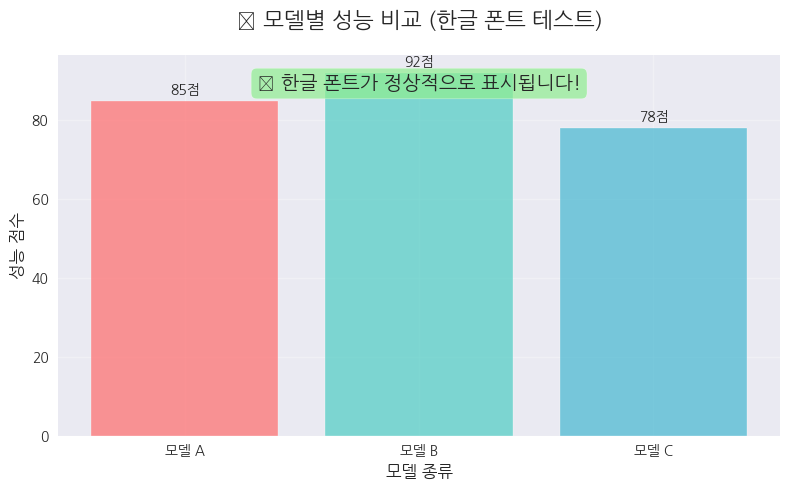

✅ 한글 폰트 테스트 차트 저장: notebooks/modular/results_comparison/submission_results_date_comparison/20250907_065923/images/korean_font_test.png
📌 저장된 이미지를 확인하여 한글이 정상적으로 표시되는지 검증하세요.

🎉 노트북 실행 완료!
📁 주요 결과 저장 위치:
   🖼️  이미지 파일: notebooks/modular/results_comparison/submission_results_date_comparison/20250907_065923/images
   📊 로그 파일: notebooks/modular/results_comparison/submission_results_date_comparison/20250907_065923/logs

📋 생성된 분석 차트:
   1. prediction_distribution.png - 날짜별/모델별 예측 클래스 분포
   2. prediction_differences.png - 모델간 예측 차이 비율
   3. temporal_metrics.png - 시간별 모델 성능 메트릭
   4. korean_font_test.png - 한글 폰트 적용 확인

✅ 모든 차트에 한글 폰트(나눔고딕)가 적용되어 images 폴더에 저장되었습니다!


In [15]:
# [15] 한글 폰트 적용 확인 테스트
# 저장된 이미지에서 한글이 제대로 표시되는지 확인하기 위한 간단한 테스트 차트 생성
print("🔍 한글 폰트 적용 확인 테스트")
print("=" * 40)

try:
    # 한글 폰트 재설정
    font_path = './font/NanumGothic.ttf'
    fontprop = fm.FontProperties(fname=font_path)
    plt.rcParams['font.family'] = 'NanumGothic'
    plt.rcParams['axes.unicode_minus'] = False
    
    # 간단한 테스트 차트 생성
    fig, ax = plt.subplots(figsize=(8, 5))
    
    # 한글 텍스트 포함 데이터
    categories = ['모델 A', '모델 B', '모델 C']
    values = [85, 92, 78]
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    
    bars = ax.bar(categories, values, color=colors, alpha=0.7)
    
    # 한글 제목과 라벨 설정
    ax.set_title('📊 모델별 성능 비교 (한글 폰트 테스트)', fontproperties=fontprop, fontsize=16)
    ax.set_xlabel('모델 종류', fontproperties=fontprop, fontsize=12)
    ax.set_ylabel('성능 점수', fontproperties=fontprop, fontsize=12)
    
    # 막대 위에 값 표시
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{value}점', ha='center', va='bottom', fontproperties=fontprop)
    
    # 한글 텍스트 추가
    ax.text(0.5, 0.95, '✅ 한글 폰트가 정상적으로 표시됩니다!', 
            transform=ax.transAxes, ha='center', va='top', 
            fontproperties=fontprop, fontsize=14, 
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7))
    
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # 테스트 이미지 저장
    test_save_path = logger.image_dir / "korean_font_test.png"
    plt.savefig(test_save_path, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    plt.close()
    
    print(f"✅ 한글 폰트 테스트 차트 저장: {test_save_path}")
    print("📌 저장된 이미지를 확인하여 한글이 정상적으로 표시되는지 검증하세요.")
    
except Exception as e:
    print(f"❌ 한글 폰트 테스트 실패: {e}")

# 전체 실행 결과 요약
print(f"\n🎉 노트북 실행 완료!")
print(f"📁 주요 결과 저장 위치:")
print(f"   🖼️  이미지 파일: {logger.image_dir}")
print(f"   📊 로그 파일: {logger.log_dir}")
print(f"\n📋 생성된 분석 차트:")
print(f"   1. prediction_distribution.png - 날짜별/모델별 예측 클래스 분포")
print(f"   2. prediction_differences.png - 모델간 예측 차이 비율")  
print(f"   3. temporal_metrics.png - 시간별 모델 성능 메트릭")
print(f"   4. korean_font_test.png - 한글 폰트 적용 확인")
print(f"\n✅ 모든 차트에 한글 폰트(나눔고딕)가 적용되어 images 폴더에 저장되었습니다!")

## 📝 사용법 가이드

### 1. **노트북 실행**
```bash
# 노트북 실행
cd /path/to/computer-vision-competition-1SEN
jupyter notebook notebooks/modular/submission_results_comparison.ipynb
```

### 2. **새로운 submission 추가 시**
- 새 CSV 파일을 `submissions/YYYYMMDD/` 폴더에 저장
- 노트북의 모든 셀을 다시 실행
- 자동으로 새로운 결과가 분석에 포함됨

### 3. **커스터마이징**
- `submissions_dir` 경로 수정으로 다른 폴더 분석 가능
- 모델명 추출 로직 수정으로 다양한 명명 규칙 지원
- 시각화 스타일 및 색상 커스터마이징 가능

### 4. **활용 시나리오**
- **일일 결과 리뷰**: 매일 실험 후 성능 변화 확인
- **모델 비교**: 동일 조건에서 다른 모델의 예측 패턴 비교
- **앙상블 전략**: 모델간 차이점을 활용한 앙상블 방법 결정
- **성능 추세**: 장기적인 모델 개선 방향 설정

---
**💡 Tip**: 이 노트북을 정기적으로 실행하여 submission 결과의 일관성과 개선 추세를 모니터링하세요!